### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [13]:
BOS, EOS = ' ', '\n'

data = pd.read_json("arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [14]:
tokens = set(''.join(lines))
tokens = sorted(tokens)
n_tokens = len(tokens)
print('n_tokens = ', n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [15]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [16]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [17]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [18]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
import torch
import torch.nn as nn

class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens, emb_size=16, hid_size=64):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, emb_size)
        self.padding = nn.ZeroPad2d((4, 0, 0, 0))  # Pad left by 4 zeros
        self.conv1d = nn.Conv1d(emb_size, hid_size, kernel_size=5, stride=1, padding=0)
        self.linear = nn.Linear(hid_size, n_tokens)
    
    def forward(self, input_ix):
        """
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
        """
        embedded = self.embedding(input_ix)

        embedded = embedded.permute(0, 2, 1)
        padded = self.padding(embedded.unsqueeze(1))
        padded = padded.squeeze(1)
        conv_out = self.conv1d(padded)

        logits = self.linear(conv_out.permute(0, 2, 1))
        
        return logits
    
    def get_possible_next_tokens(self, prefix, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            logits = self(prefix_ix)
            probs = torch.softmax(logits[0, -1] / temperature, dim=-1).cpu().numpy()
        return dict(zip(tokens, probs))


In [40]:
dummy_model = FixedWindowLanguageModel(len(token_to_id))

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('embedding.weight', 'conv1d.weight', 'conv1d.bias', 'linear.weight', 'linear.bias')


In [41]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [42]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [43]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [44]:
import torch
import torch.nn.functional as F

def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input_ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    batch_size, seq_len = reference_answers.size()
    logits_flat = logits.reshape(-1, logits.size(-1))
    targets_flat = reference_answers.reshape(-1)

    eos_ix = 0
    mask = (targets_flat != eos_ix).float()

    loss = F.cross_entropy(logits_flat, targets_flat, reduction='none')
    masked_loss = loss * mask
    mean_loss = masked_loss.sum() / mask.sum()
    
    return mean_loss


In [45]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [46]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [47]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel(n_tokens=len(token_to_id))
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingkÖ?LYTλHLö|!1I/&5>3qjïáβÖΣGOμ]üőbPŁOr[{=m/í?Ł%=õ@ő`ÜLM2Cx?öôdõb|lγ



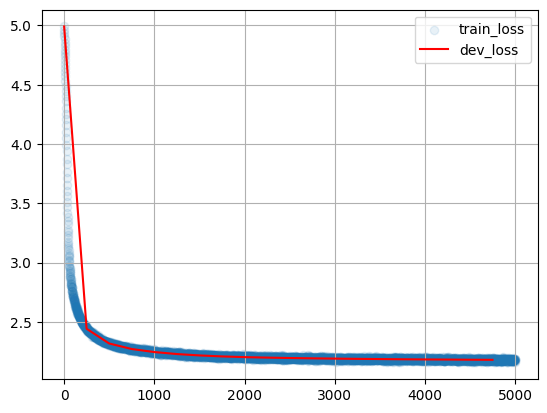

Generated examples (tau=0.5):
 serem no plene tho se thathis demalizationt de poral sedsethe the serelecente tere the the seanco so
 Hiand Semporich Seproblemations an works cally thation ich the that inal intwerog and ain problem or
 Grapision the and complitict or ar aperition the s mathe s perel fict ablem the s athe ssor the r an
Scoring dev...


100%|██████████| 5000/5000 [38:15<00:00,  2.18it/s]

#4999 Dev loss: 2.179


In [48]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [49]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 2.178620497401168
 ARNNewith as pareang althe nos and tual of ras ing aimint at on foratime of and al arerent orention 
 Se the sestion byete time of extutinn for belation sforme thes thod ing gativera de probenity the tr
 ne word cha ne wne the on tho pation or the coure tha de pore steris tod ex medel arde s aperally se
 An the raperection ; The precal bysed ation ander sed the reations the somplexistin tof s ar ar Alge
 apres ingon the s are the model sinf amele the frequentwe the the late tare thath s pucer an ale ghe
 Con restementres con and capling forsimale anterable tion ; In the s athen whe procont aremogriss ty
 Avere tomalt ontict or chere tront mation at in and on the pres at or hinge cos of chive the s probe
 A Mone s and inal betron se gevel tere shond of s abien ss omparion thes are trodut des ande th weat
 Bathe procon of the decention ; Furation probeted fored the modis (DMonticl areprencag teding and th
 Deraching ther prepris anderenon tion atien for

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens, emb_size=16, hid_size=256):
        """
        Build a recurrent language model.
        :param n_tokens: number of tokens in the vocabulary
        :param emb_size: size of the embedding vectors
        :param hid_size: size of the hidden state in RNN layers
        """
        super(RNNLanguageModel, self).__init__()

        self.embeddings = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.rnn = nn.LSTM(input_size=emb_size, hidden_size=hid_size, batch_first=True)
        self.linear = nn.Linear(hid_size, n_tokens)
    
    def forward(self, input_ix):
        """
        Compute language model logits given input tokens.
        :param input_ix: batch of sequences with token indices, tensor: int64[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
        """
        embedded = self.embeddings(input_ix)
        rnn_out, _ = self.rnn(embedded)

        logits = self.linear(rnn_out)
        
        return logits
    
    def get_possible_next_tokens(self, prefix, temperature=1.0, max_len=100):
        """
        Generate possible next tokens given a prefix.
        :param prefix: initial sequence of token indices
        :param temperature: control the randomness of predictions
        :param max_len: maximum length of the generated sequence
        :returns: probabilities of next token, dict {token : prob} for all tokens
        """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            logits = self(prefix_ix)
            probs = torch.softmax(logits[0, -1] / temperature, dim=-1).cpu().numpy()
        
        return dict(zip(tokens, probs))


In [52]:
model = RNNLanguageModel(n_tokens=len(token_to_id))

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('embeddings.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'linear.weight', 'linear.bias')


In [53]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [54]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel(n_tokens=len(token_to_id))
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingïGdW_Ü&ïσ°4ï!1Σ?8TÉ3Xt#i=~~yLOõΣ5oj°qV>É9áεb[!Éő-s;;}~z$B1gbő`áäR.N-μDFI.VW3dh0σεG?i>aM*σ2


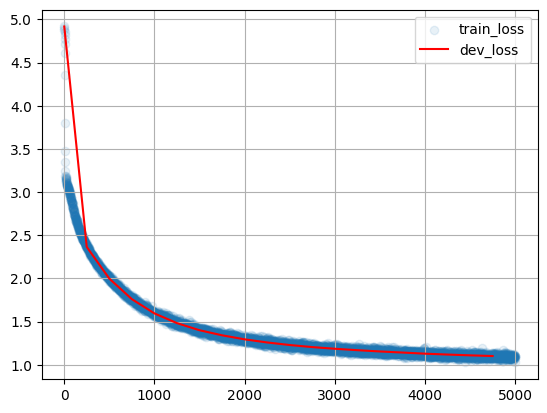

Generated examples (tau=0.5):
 A Convolutional Neural Network of Multi-Steptical Eread Estimation ; This paper presents a novel met
 The Constrained Deep Neural Networks for Neural Networks ; This paper describes a matrix decision is
 The Search of Algorithm for Compositional Structure ; Recently extended by experts the problem of co
Scoring dev...


100%|██████████| 5000/5000 [1:36:59<00:00,  1.16s/it]

#4999 Dev loss: 1.094


In [55]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i = compute_loss(model, batch)
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [56]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.0941173076397035
 A How detection from Constraint Conditional Constraint ; We propose a novel approach to the similari
 Semantic Simulation of Community ; This consistency of the application of the separation of the prob
 Computational Logic System for Comprehensive Assessment ; Statistical model with the state of sensor
 Deep Learning for Sparse Signal Constraints ; In this paper, we propose a constraint entities of the
 Sequence Comparing Convolutional Neural Networks ; Sequence the proposed method to the problem of in
 Fast Visual Video Stochastic Approach ; Deep learning techniques for many detection in the models wi
 A Theory learning for Scientific Structure ; The plan annotation for the method for the signals and 
 Deep Representations by Efficient Learning ; In this paper, we propose a new method and success is a
 Foreground Alternative Approach for Interacting Subspaces ; In this paper, we propose a new sentimen
 An Interpretate Data Scale Particularly ; In t

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [62]:
import random 
def generate_nucleus(model, prefix="BOS", nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus (top-p) sampling.
    :param model: language model providing next-token probabilities.
    :param prefix: a string containing space-separated previous tokens.
    :param nucleus: threshold for cumulative probability (N ∈ [0, 1]).
    :param max_len: generate sequences with at most this many tokens, including prefix.
    :return: generated sequence.
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())

        sorted_indices = sorted(range(len(probs)), key=lambda i: probs[i], reverse=True)
        sorted_tokens = [tokens[i] for i in sorted_indices]
        sorted_probs = [probs[i] for i in sorted_indices]

        cumulative_probs = []
        total_prob = 0
        for prob in sorted_probs:
            total_prob += prob
            cumulative_probs.append(total_prob)
            if total_prob > nucleus:
                break

        top_p_tokens = sorted_tokens[:len(cumulative_probs)]
        next_token = random.choice(top_p_tokens)
        prefix += " " + next_token
        if next_token == "EOS" or len(prefix.split()) >= max_len:
            break

    return prefix

In [63]:
for i in range(10):
    print(generate_nucleus(model))

BOS ! h i t h i m o n e r e m e m o n o n a n o b e n o b e p r a d o f l o n e q u t h i m e v i s a   o p o p l e v i s p r e q u n o n o n a p o b i m o n o b i m e s t h e q u s t h e m e m a d i d e
BOS à \ e q u s t a r e c h e a n o n e a t o f e a t o b i m o b l e a s o r a s o p a   - i s c h e a r i d e s i s c o n e s h a s t a r a l o p o b e f o b l i n o u n o d a n o b i m e x e s e v i n
BOS e v a   - i m o f e v a     R e v i t o p o p l a b i s u n o d e a   S i n o p l e n e r e f i m e v i t w e m a s y   n o b u n o d i m i s c o b i s c h a p r a n e f u n o d i n o d i m a   f u s o p l e x
BOS < M e a p r a s p a c h o d e a r a   f r e x e t o t h a d i s t o p o p e x e s u p r a     S p r o u p r o p o b r o p a p a     s u s t e l e m a n e m a   M i s e f i t w o b r o r a c l a r e x i s i n a
BOS % e v i n e r e v e n o n a m e n e x i n o f o u n o p a r e a l i t a s u n o d i s t h i m e x e v i m e v a n o f i t a d e s t h i n e a s y   r e c a s e 

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [ ]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [66]:
import heapq
import math

def generate_beamsearch(model, prefix="BOS", beam_size=4, length=5):
    """
    Generate a sequence with beam search.
    :param model: language model providing next-token probabilities.
    :param prefix: a string containing space-separated previous tokens.
    :param beam_size: the number of sequences to keep track of at each step.
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX.
    :returns: list of the beam_size most likely candidates (sequences).
    """
    beam = [(0, prefix)]

    for _ in range(length):
        new_beam = []
        for log_prob, seq in beam:
            token_probs = model.get_possible_next_tokens(seq)
            
            for token, prob in token_probs.items():
                new_log_prob = log_prob + math.log(prob)

                new_seq = seq + " " + token
                new_beam.append((new_log_prob, new_seq))

        beam = heapq.nlargest(beam_size, new_beam, key=lambda x: x[0])

    return [seq for _, seq in beam]

In [79]:
generate_beamsearch(model, prefix=' deep ', beam_size=4)

[' deep  n e x e s',
 ' deep  l a s t o',
 ' deep  n e x e f',
 ' deep  n e x e m']

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_